In [1]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [2]:
NOTE = 'LightGBM-goss特徴量ミニマム'
notebook_name = '054'

N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

054_submission.csv 054


In [3]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  vector_features=None,
                  features=None) -> Pipeline:

    clf = LGBMClassifier(random_state=SEED,
                         class_weight='balanced',
                         importance_type='gain',
                         boosting_type='goss',
                         n_jobs=-1,
                         n_estimators=300,
                         learning_rate=0.01)
    return Pipeline(
        steps=[
            ('estimator', clf)
         ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
CATEGORICAL_FEATURES

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
discrete_features = list(set(minimal_features) - set(categorical_features))
print(categorical_features)
print(discrete_features)

# Execute if categories should be one-hot style
# for c in categorical_features:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])

# train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
# test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

# categorical_features_1hot = []
# for c in categorical_features:
#     categorical_features_1hot += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
# print(categorical_features_1hot)

# features = discrete_features + categorical_features_1hot
features = discrete_features + categorical_features

['b1', 'b2', 'b3', 'batterID', 'pitcherID', 'Match', 'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher', 'isBottom', 'batterTeam', 'pitcherTeam']
['S', 'B', 'inningNo', 'O', 'totalPitchingCount', 'numRunners']


In [7]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )

    clf = get_estimator(features=features,
                        discrete_features=discrete_features,
                        categorical_features=categorical_features)
#     class_weight = compute_class_weight('balanced',
#                                         classes=np.sort(train.y.unique()),
#                                         y=y_train.values)
#     class_weight = dict(
#         zip(
#             np.sort(train.y.unique()),
#             class_weight
#         )
#     )
#     sample_weight = y_train.map(class_weight)
#     assert(sample_weight.isnull().sum() == 0)
    sample_weight = None
    clf.fit(X_train, y_train.values, estimator__sample_weight=sample_weight)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



**********Confusion matrix for train set (Fold 1)**********
[[1444 1267  470  671  539  343   12  320]
 [ 496 1700  277  413  357  253   11  239]
 [ 323  402  689  388  268  188    8  127]
 [ 172  247  120  796  175  102    2   95]
 [  21   40   10   26  398   20    2   23]
 [   0    1    0    0    0  149    0    0]
 [   0    0    0    0    0    0    8    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 1)**********
[[272 351 120 179 155 104   5  81]
 [164 346  82 117  89  65   5  68]
 [ 79 108  88 129  94  56   0  45]
 [ 58  67  60  95  74  48   2  23]
 [ 17  21  21  22  26  14   0  14]
 [  7   4   3   9   7   6   0   1]
 [  1   0   0   1   0   0   1   0]
 [  1   7   3   2   4   2   0   5]]

**********Confusion matrix for train set (Fold 2)**********
[[1508 1288  450  619  585  320   20  276]
 [ 514 1739  249  407  371  244   18  204]
 [ 334  414  664  376  290  176    3  136]
 [ 200  246  114  749  202  106   12   80]
 [  34   46   1

In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.332085,0.153295
std,0.006829,0.009377
min,0.325762,0.142873
25%,0.326250,0.145596
50%,0.330322,0.154790
75%,0.336546,0.156947
max,0.341546,0.166266


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,7,0,1
2,2,0,2,0,1
3,3,2,2,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,3,0,5
17130,16833,1,1,0,5
17133,9762,1,1,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.109135,0.138104,0.152744,0.244896,0.122220,0.120684,0.048506,0.063710,27446,1
1,0.196716,0.135117,0.192006,0.131414,0.104962,0.072282,0.109943,0.057560,113,1
2,0.147234,0.303605,0.171506,0.053490,0.051427,0.031379,0.197395,0.043965,4479,1
3,0.204561,0.255059,0.142714,0.216301,0.063089,0.044041,0.007799,0.066436,29080,1
4,0.202951,0.133195,0.239387,0.187714,0.109497,0.071514,0.012428,0.043314,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.195058,0.301104,0.109782,0.100992,0.180468,0.024288,0.009850,0.078458,24272,5
33804,0.088671,0.191985,0.276519,0.219134,0.162169,0.020437,0.006746,0.034339,29106,5
33805,0.110518,0.158964,0.251631,0.268726,0.141428,0.023141,0.006871,0.038721,20679,5
33806,0.286811,0.206433,0.165966,0.162372,0.139948,0.013532,0.007535,0.017403,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.729710,0.894815,0.886317,0.825931,0.762698,0.532253,0.057201,0.311075
1,1,1.196418,1.475119,0.680106,0.664734,0.558447,0.289739,0.044333,0.091104
2,2,0.327921,0.300814,1.273786,1.398539,0.785110,0.335313,0.068525,0.509992
3,3,1.005242,1.305617,0.570842,0.644262,0.540066,0.269091,0.037588,0.627293
4,4,1.234191,1.634674,0.556173,0.625715,0.528924,0.233045,0.039003,0.148276
...,...,...,...,...,...,...,...,...,...
33803,33803,1.097582,0.797272,0.892051,0.907957,0.493310,0.545106,0.058935,0.207786
33804,33804,1.286911,1.045732,0.615539,0.581718,1.180387,0.135302,0.032467,0.121944
33805,33805,1.260967,0.944211,0.673950,1.061002,0.614586,0.284583,0.032066,0.128636
33806,33806,0.667964,0.748746,0.750172,0.956514,0.750841,0.596031,0.111830,0.417902


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,3
3,3,1
4,4,1
...,...,...
33803,33803,0
33804,33804,0
33805,33805,0
33806,33806,3


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.221072
1    0.375385
2    0.072291
3    0.135915
4    0.119558
5    0.032300
6    0.003638
7    0.039843
Name: y, dtype: float64

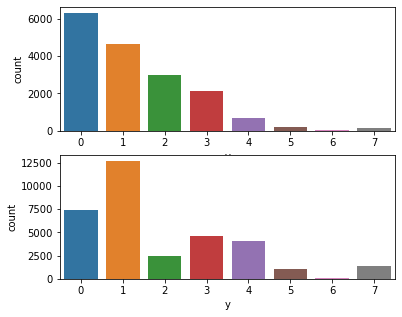

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.3320852106398123, 0.15329453965084322)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"054_submission.csv","Stratified-Kfold(K=5)","0.332085","0.153295","","LightGBM-goss特徴量ミニマム"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 869 ms


In [20]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 18.5 ms


In [21]:
imp_df

,feature,importance,fold
0,S,63308.676379,1
1,B,75959.547935,1
2,inningNo,162342.029940,1
3,O,114736.885490,1
4,totalPitchingCount,88519.376280,1
...,...,...,...
13,isPitcherHandLeft,22873.001337,5
14,isBatterPitcher,7493.671912,5
15,isBottom,22357.039889,5
16,batterTeam,4851.840462,5


In [22]:
%%time
coef_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [23]:
coef_df

""
